In [2]:
import numpy as np
import imageio
from matplotlib import pyplot as plt
import math

In [3]:
class OutputBitstream:
    def __init__(self, filename):
        self.filename = filename
       
    def __enter__(self):
        self.word = 0
        self.word_bits = 0
        self.file = open(self.filename, "wb")
        return self
       
    def write(self, value, length):
        assert isinstance(value, int), "value must be integer"
        assert isinstance(length, int), "length must be integer"
        assert value >= 0, "value must be non negative"
        assert value < 2 ** length, "value must be smaller than 2 ** length"
       
        self.word <<= length
        self.word |= value
        self.word_bits += length
   
        if self.word_bits >= 64:
            remaining = self.word_bits - 64
            self.file.write((self.word >> remaining).to_bytes(8, byteorder="big", signed=False))
            self.word &= (1 << remaining) - 1
            self.word_bits = remaining
   
    def __exit__(self, exc_type, exc_val, exc_tb):
        if self.word_bits != 0:
            self.write(0, 64 - self.word_bits)
           
        self.file.close()

In [4]:
class InputBitstream:
    def __init__(self, filename):
        self.filename = filename
       
    def __enter__(self):
        self.word = 0
        self.word_bits = 0
        self.file = open(self.filename, "rb")
        return self
       
    def read(self, length):
        assert length < 8 * 32, "length is too large"
       
        if length > self.word_bits:
            value = self.file.read(32)
            self.word <<= len(value) * 8
            self.word_bits += len(value) * 8
            self.word |= int.from_bytes(value, byteorder="big", signed=False)
           
        if length > self.word_bits:
            raise "Unexpected end of file"
               
        result = self.word >> (self.word_bits - length)
        self.word_bits -= length
        self.word &= (1 << self.word_bits) - 1
       
        return result
   
    def __exit__(self, exc_type, exc_val, exc_tb):    
        self.file.close()

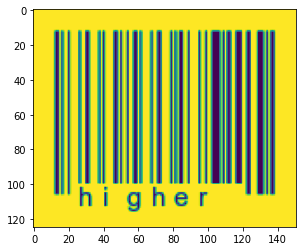

In [5]:
img = imageio.imread("barcodes/sample-000002.png")
plt.imshow(img) #im

primeraLinea = 0
segonaLinea = 0
ultimaRepetida = 0
margeInferior = 0

for fila in range(img.shape[0]):
    for columna in range(img.shape[1]):
        if img[fila][columna] != 255:
            if primeraLinea == 0:
                primeraLinea = fila
                segonaLinea = fila+1


segonaLinea = img[segonaLinea]

for x in range(primeraLinea+1, img.shape[0]):
    
    if False in (img[x] == segonaLinea):
        if ultimaRepetida == 0:
            ultimaRepetida = x


for i in range(img.shape[0]):
    if img[i][12] != 255:
        margeInferior = i


            
#Left Margin
leftMargin = 0
           
for i in range(len(img[ultimaRepetida])):
    if img[ultimaRepetida-1][i] != img[ultimaRepetida][i]:
        if leftMargin ==0:
            leftMargin = i

            
            
#Right Margin
rightMargin = 0
anterior = 0

#for i in reversed(range(len(img[ultimaRepetida]))):
for i in reversed(range(img.shape[1])):
    if img[ultimaRepetida-1][i] != img[ultimaRepetida][i]:
        if rightMargin ==0:
            rightMargin = anterior
    anterior = i
            
            
#print(margeInferior)
#print(leftMargin)
#print(rightMargin)
#print('---------')
#print(primeraLinea)
#print(segonaLinea)
#print("La fila es repeteix fins la fila", ultimaRepetida)


In [6]:
#Fins ara tenim una funcio que retorna la ultima fila que es repeteix dins del barcode
# codeBook = primeraLinia + SegonaLinia + totes les linies que no es repeteixen
# a cada linia li podem dir codeword
# per ara hardcodegem les mesures, ja les enviarem

#codeBook =[]
#codeBook.append(img[primeraLinea])
#codeBook.append(segonaLinea)

#wordImage = []

#for i in range(ultimaRepetida, img.shape[0]):
#    for value in img[i]:   
#        wordImage.append(value)
#    codeBook.append(img[i])
#wordImageNP = np.array(wordImage)
#wordImageNP.resize(img.shape[1],img.shape[0]-ultimaRepetida)

#print("Generat Codebook")


In [7]:
def getMSE(img1, img2):  # MSE of 2 images
    return (np.sum(np.square(img1 - img2))) / img1.size


In [8]:
#Obtenir la primera a partir de la segona --> mitja del valor i color blanc(255)

def getFirstLine(common):
    computedPrimera = []

    for el in common:
        newVal = (el+255)//2
        if newVal> (el+(255//2)+0.5):
            newVal+=1
        computedPrimera.append(newVal)
    
    return computedPrimera


def getLastLine(common):
    computedLast = []

    for el in common:
        if el != 255:
            newVal = (el+255)//1.77
            if newVal> (el+(255//1.77)+0.5):
                newVal+=1
        else:
            newVal = 255
        computedLast.append(newVal)
            
    return computedLast


In [9]:
shape_x = img.shape[1]
shape_y = img.shape[0]

test1 = np.asarray(img[13]) #common row
test1 = test1.tolist()


#remove first and last 12 255
test = test1[12:-12]

#print(test)


#write
with open('test222.bin', "wb+") as f:
    
    #header
    f.write(shape_y.to_bytes(3, byteorder="big", signed=False))
    f.write(shape_x.to_bytes(3, byteorder="big", signed=False))
    
    
    for i in range(len(test)):
        f.write(test[i].to_bytes(3, byteorder="big", signed=False))
    
    for i in range(12, leftMargin):
        f.write(int(img[margeInferior][i]).to_bytes(3, byteorder="big", signed=False))
    
    for i in range(rightMargin, shape_x):
        f.write(int(img[margeInferior][i]).to_bytes(3, byteorder="big", signed=False))
            
            
#read 
commonLine =[]

with open('test222.bin', "rb") as f:
    testReconstructed = []
    read = f.read()
    i=0
    cont=0
    ultimaRepetida = 100
    
    #header
    reconstructed_y = int.from_bytes(read[:3], byteorder="big")
    reconstructed_x = int.from_bytes(read[3:6], byteorder="big")
    
    
    ultimaLinea = [255 for i in range(reconstructed_x)]
    
        
    read = read[6:]
    
    
    for j in range(len(test)):
    
        commonLine.append(int.from_bytes(read[i:i+3], byteorder="big"))
        i+=3
    
    
    #ultima linea
    for j in range(12, leftMargin):
        ultimaLinea[j] = int.from_bytes(read[i:i+3], byteorder="big")
        i+=3
        
    
    for j in range(rightMargin, shape_x):
        ultimaLinea[j] = int.from_bytes(read[i:i+3], byteorder="big")
        i+=3


#reconstruir

#12 first 255
finalReconstructed = [255 for x in range(12)]

#12 last 255
for i in range(12):
    commonLine.append(255)

    
finalReconstructed += commonLine


#print(finalReconstructed)

primera = getFirstLine(finalReconstructed)
ultima = getLastLine(finalReconstructed)


img_reconstructed = np.array([[255 for x in range(shape_x)] for j in range(shape_y)])

#asignem la primera fila
img_reconstructed[12] = primera
img_reconstructed[13:ultimaRepetida] = finalReconstructed



#laterals:

#LEFT
for i in range(ultimaRepetida, margeInferior):
    for j in range(leftMargin):
        img_reconstructed[i][j] = finalReconstructed[j]

#RIGHT
for i in range(ultimaRepetida, margeInferior):
    for j in reversed(range(rightMargin, reconstructed_x)):
        img_reconstructed[i][j] = finalReconstructed[j]

        
#Last Line
for j in range(12, leftMargin):
    img_reconstructed[margeInferior][j] = ultimaLinea[j]

for j in reversed(range(rightMargin, reconstructed_x-12)):
    img_reconstructed[margeInferior][j] = ultimaLinea[j]



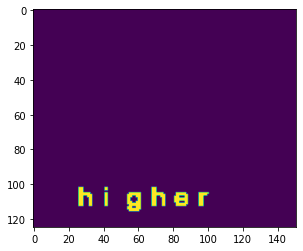

In [10]:
right = np.array([[255 for x in range(shape_x)] for j in range(shape_y)])

for i in range(shape_y):
    for j in range(shape_x):
        if img[i][j] == img_reconstructed[i][j]:
            right[i][j] = 0
        
            
        
plt.imshow(np.asarray(right))        

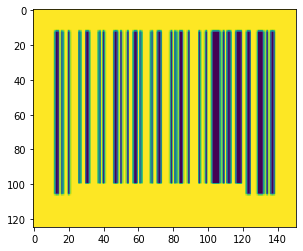

In [11]:
plt.imshow(np.asarray(img_reconstructed))

In [12]:
def rel_freq(x):
    freqs = [(value, x.count(value) / len(x)) for value in set(x)] 
    return sorted(freqs,key=lambda x:x[::-1],reverse=True)

In [13]:
print(shape_y)

125


In [18]:
print((531*8)/(shape_x*shape_y)) #calcul dels bps actuals

0.22505960264900662
